# [IAPR][iapr]: Lab 2 ‒  Object description


**Group ID:** 46

**Author 1 (sciper):** Pierre-Jean Martin (258890)  
**Author 2 (sciper):** Louis Rostaing (257238)   
**Author 3 (sciper):** Yanis Bouadi (283606)   

**Release date:** 26.03.2021  
**Due date:** 23.04.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

## 0. Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
data_part1 = os.path.join(data_base_path, data_folder, 'part1')
data_part2 = os.path.join(data_base_path, data_folder, 'part2')

tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try:
1. Fourier Descriptors (15pts). 
    1. Implementation (10 pts).
    2. Showing invariance to rotation, translation and scaling (5 pts).
2. Additional method of your choice (5 pts)


**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point. Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

### 1.1 Data visualization

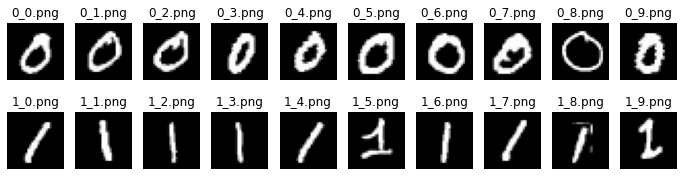

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

def load(path, digit='0'):
    digit_path = os.path.join(path, digit)
    digit_names = [nm for nm in os.listdir(digit_path) if '.png' in nm]  # make sure to only load .png
    digit_names.sort()  # sort file names
    ic = skimage.io.imread_collection([os.path.join(digit_path, nm) for nm in digit_names])
    digit_im = skimage.io.concatenate_images(ic)
    return digit_im, digit_names
                        
#  Load zeros and ones
zeros_im, zeros_names = load(data_part1, digit='0')
ones_im, ones_names = load(data_part1, digit='1')


# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors (15 pts)

In [3]:
#importing libraries

from skimage import measure, morphology
import numpy as np
from scipy.fftpack import fft2, fft, ifft2, fftshift
from skimage.morphology import opening, erosion, square, closing, disk, dilation
from skimage.transform import rotate, rescale, SimilarityTransform
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

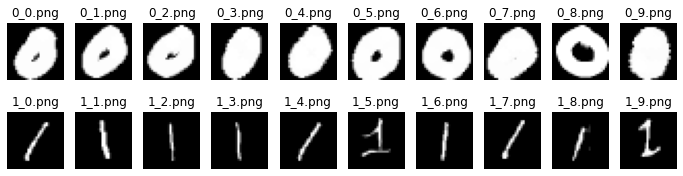

In [4]:
#First, let's do a pre-processing on the images 

for i in range(len(zeros_im)):
    
    zeros_im[i] = skimage.morphology.area_closing(zeros_im[i])
    zeros_im[i] = skimage.morphology.dilation(zeros_im[i], disk(3))
   
    
for i in range(len(ones_im)):
    
    ones_im[i] = skimage.morphology.erosion(ones_im[i],square(2))
    

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

In [5]:
#This function returns a list with the coordinates of the contour 
#The input 'image' has to be a 28*28 array : ex: ones_im[0] or ones_im[1]

def Get_Contour_Coordinates(image):
    
    cont=measure.find_contours(image,50) # 70 corresponds to the grey value from which we start detecting the contour
    coordinates=[] 
    
    for k in range(len(cont[0])):

        x_k=cont[0][k][0]
        y_k=cont[0][k][1]
        z=[x_k,y_k]
        coordinates.append(z)
    
    coordinates = np.array(coordinates)
    
    return coordinates



In [6]:
#This function gives the Fourier Descriptors f_1 and f_2 of the contour

def Fourrier_Descriptors(picture):
    
    coordinates= Get_Contour_Coordinates(picture)    
    Fourier_descriptor= fft2(coordinates)
    A=[abs(Fourier_descriptor[1])[0]/abs(Fourier_descriptor[0])[0],abs(Fourier_descriptor[2])[0]/abs(Fourier_descriptor[0])[0]]
   
    return A
    

In [7]:
#This function collects the Fourier Descriptors of all the images in the dataset 

def Get_Data(image):
    
    data=[]
    
    for img in image:
        
        data.append(Fourrier_Descriptors(img))
    #print(data)
    return data


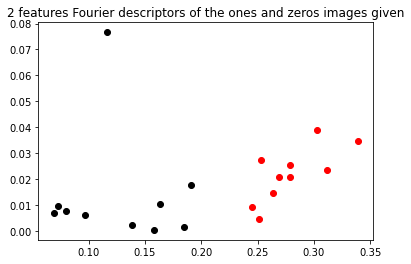

In [8]:
#Here, we are associating each image to a point: 20 images --> 20 points 
#The goal is to see if a classification can be pointed out from a plot

Coordinates_zeros=Get_Data(zeros_im)
Coordinates_ones=Get_Data(ones_im)

X_ones = [x[0] for x in Coordinates_ones]
Y_ones = [x[1] for x in Coordinates_ones]

X_zeros = [x[0] for x in Coordinates_zeros]
Y_zeros = [x[1] for x in Coordinates_zeros]

plt.scatter(X_ones,Y_ones, color='black')
plt.scatter(X_zeros,Y_zeros, color='red')
plt.title('2 features Fourier descriptors of the ones and zeros images given')
plt.show()

### Here, we clearly see the distinction between the images representing zeros from the images representing ones. The Fourier Descriptors method works well for this dataset.

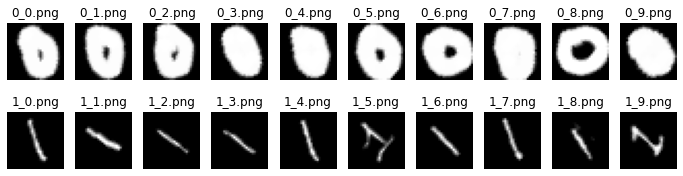

In [9]:
#Let's test the rotation invariance

for i in range(len(zeros_im)):
    
    ones_im[i] = skimage.transform.rotate(ones_im[i],angle=50,preserve_range=True)
    zeros_im[i] = skimage.transform.rotate(zeros_im[i],angle=50,preserve_range=True)

    

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)


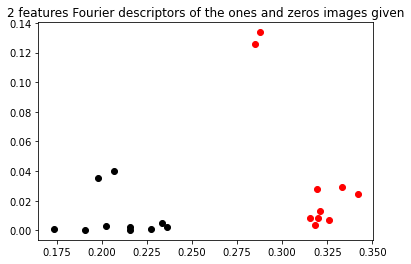

In [10]:
#Here, we are associating each image to a point: 20 images --> 20 points 
#The goal is to see if a classification can be pointed out from a plot

Coordinates_zeros=Get_Data(zeros_im)
Coordinates_ones=Get_Data(ones_im)

X_ones = [x[0] for x in Coordinates_ones]
Y_ones = [x[1] for x in Coordinates_ones]

X_zeros = [x[0] for x in Coordinates_zeros]
Y_zeros = [x[1] for x in Coordinates_zeros]

plt.scatter(X_ones,Y_ones, color='black')
plt.scatter(X_zeros,Y_zeros, color='red')
plt.title('2 features Fourier descriptors of the ones and zeros images given')
plt.show()

### Here, we can see that the classification is obvious even after a rotation of the images. A rotation affects only the phase (not the amplitude) of the Fourier Descriptors by the same amount.


### 1.3 Additional method (5 pts)

### In the next section, we will use a region-based descriptors: Axes of inertia

In [11]:
def Inertia_Descriptors(picture):
    
    tensors_eig=skimage.measure.inertia_tensor_eigvals(picture)
    #print([tensors_eig[0],tensors_eig[1]])
    
    return [tensors_eig[0],tensors_eig[1]]

In [12]:
#This function collects the Inertial Descriptors of all the images in the dataset 

def Get_Inertial_Data(picture):
    
    Data=[]
    
    for img in picture:
        
        Data.append(Inertia_Descriptors(img))
        
    return Data

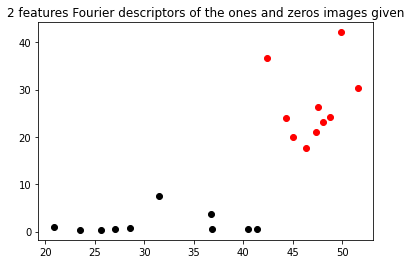

In [13]:
#Here, we are associating each image to a point: 20 images --> 20 points 
#The goal is to see if a classification can be pointed out from a plot

Coordinates_zeros=Get_Inertial_Data(zeros_im)
Coordinates_ones=Get_Inertial_Data(ones_im)

X_ones = [x[0] for x in Coordinates_ones]
Y_ones = [x[1] for x in Coordinates_ones]

X_zeros = [x[0] for x in Coordinates_zeros]
Y_zeros = [x[1] for x in Coordinates_zeros]

plt.scatter(X_ones,Y_ones, color='black')
plt.scatter(X_zeros,Y_zeros, color='red')
plt.title('2 features Fourier descriptors of the ones and zeros images given')
plt.show()

### We can clearly see the classification between of ones and zeros using region-based descriptors such as the inertia.

---
## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

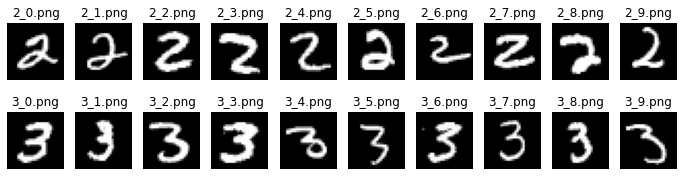

In [14]:
# Load twos and threes images
twos_im, twos_names = load(data_part2, digit='2')
threes_im, threes_names = load(data_part2, digit='3')

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Fourier descriptors - 4 digits (10 pts)

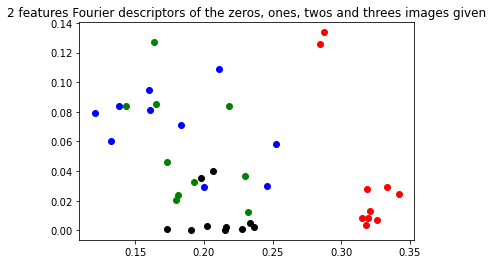

In [15]:
#Here, we are associating each image to a point: 40 images --> 40 points 
#The goal is to see if a classification can be pointed out from a plot

Coordinates_zeros=Get_Data(zeros_im)
Coordinates_ones=Get_Data(ones_im)
Coordinates_twos=Get_Data(twos_im)
Coordinates_threes=Get_Data(threes_im)

X_ones = [x[0] for x in Coordinates_ones]
Y_ones = [x[1] for x in Coordinates_ones]

X_zeros = [x[0] for x in Coordinates_zeros]
Y_zeros = [x[1] for x in Coordinates_zeros]

X_twos = [x[0] for x in Coordinates_twos]
Y_twos = [x[1] for x in Coordinates_twos]

X_threes = [x[0] for x in Coordinates_threes]
Y_threes = [x[1] for x in Coordinates_threes]

plt.scatter(X_ones,Y_ones, color='black')
plt.scatter(X_zeros,Y_zeros, color='red')
plt.scatter(X_twos,Y_twos, color='green')
plt.scatter(X_threes,Y_threes, color='blue')

plt.title('2 features Fourier descriptors of the zeros, ones, twos and threes images given')
plt.show()

### Here, we can see that the distinction between the blue and green points is not obvious. It's difficult to classify the twos and threes using only 2 feature Fourier Descriptors.

### In the next section, we will use 3 features and plot a 3D distribution of the images

In [16]:
#This function gives the Fourier Descriptors f_1, f_2 and f_3 of the contour

def Fourrier_Descriptors_bis(picture):
    
    coordinates= Get_Contour_Coordinates(picture)    
    Fourier_descriptor= fft2(coordinates)
    A=[abs(Fourier_descriptor[1])[0]/abs(Fourier_descriptor[0])[0],abs(Fourier_descriptor[2])[0]/abs(Fourier_descriptor[0])[0],abs(Fourier_descriptor[3])[0]/abs(Fourier_descriptor[0])[0]]
   
    return A
    

In [17]:
#This function collects the Fourier Descriptors of all the images in the dataset 

def Get_Data_bis(image):
    
    data=[]
    
    for img in image:
        
        data.append(Fourrier_Descriptors_bis(img))
        
    return data

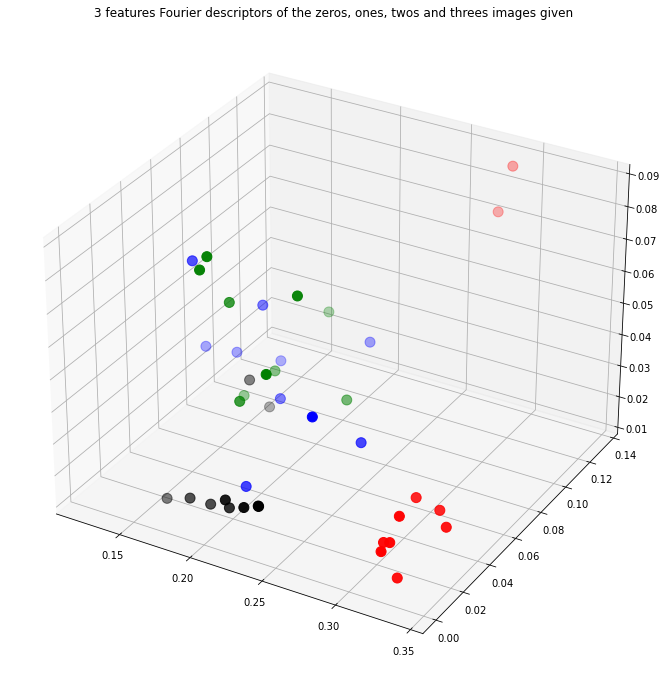

In [18]:
#Here, we are associating each image to a point: 40 images --> 40 points 
#The goal is to see if a classification can be pointed out from a plot


Coordinates_zeros=Get_Data_bis(zeros_im)
Coordinates_ones=Get_Data_bis(ones_im)
Coordinates_twos=Get_Data_bis(twos_im)
Coordinates_threes=Get_Data_bis(threes_im)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

X_ones = [x[0] for x in Coordinates_ones]
Y_ones = [x[1] for x in Coordinates_ones]
Z_ones = [x[2] for x in Coordinates_ones]

X_zeros = [x[0] for x in Coordinates_zeros]
Y_zeros = [x[1] for x in Coordinates_zeros]
Z_zeros = [x[2] for x in Coordinates_zeros]

X_twos = [x[0] for x in Coordinates_twos]
Y_twos = [x[1] for x in Coordinates_twos]
Z_twos = [x[2] for x in Coordinates_twos]

X_threes = [x[0] for x in Coordinates_threes]
Y_threes = [x[1] for x in Coordinates_threes]
Z_threes = [x[2] for x in Coordinates_threes]


ax.scatter(X_ones,Y_ones,Z_ones, color='black',s=100)
ax.scatter(X_threes,Y_threes,Z_threes, color='blue',s=100)
ax.scatter(X_zeros,Y_zeros,Z_zeros, color='red',s=100)
ax.scatter(X_twos,Y_twos,Z_twos, color='green',s=100)


plt.title('3 features Fourier descriptors of the zeros, ones, twos and threes images given')
plt.show()